<a href="https://colab.research.google.com/github/s4908819/Colab-for-COMP3710/blob/main/4.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check GPU, Python, Torch
!nvidia-smi
!python -V

# Install dependencies required by your script (nibabel / scikit-image / tqdm etc.)
!pip -q install nibabel scikit-image tqdm

# Core Idea of VAE:
# 1. Structure: VAE = Encoder + Latent space z + Decoder
#
# 2. Reparameterization trick:
#    z = μ + σ * ε
#    where μ = mean, σ = standard deviation, ε ~ N(0,1)
#    → Makes the sampling process differentiable and allows backpropagation
#
# 3. Loss function:
#    Loss = Reconstruction error + KL divergence
#    → KL divergence forces the latent distribution to be close to a standard normal


Thu Sep 18 06:47:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
%%writefile train_vae_png.py
import os, sys, json, math
from pathlib import Path
from typing import List, Tuple
import numpy as np
from skimage.io import imread
from skimage.transform import resize as sk_resize
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import argparse

def _zscore(x, eps=1e-6): return (x - x.mean())/(x.std()+eps)

class PNGDataset(Dataset):
    """VAE training for PNG slices: read PNG -> z-score -> resize -> [1,H,W]"""
    def __init__(self, img_dir: str, target_hw: Tuple[int,int]=(128,128)):
        self.paths = sorted([str(p) for p in Path(img_dir).rglob("*.png")])
        if not self.paths:
            raise RuntimeError(f"No PNG found under: {img_dir}")
        self.target_hw = target_hw

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        sl = imread(self.paths[i], as_gray=True).astype(np.float32)
        sl = _zscore(sl)
        H, W = self.target_hw
        sl = sk_resize(sl, (H,W), order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
        x = torch.from_numpy(sl[None, ...])  # [1,H,W]
        return x, 0

# ----------- VAE (same as the original) -----------
class Encoder(nn.Module):
    def __init__(self, zdim=2, base=32, in_ch=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, 2, 1), nn.BatchNorm2d(base), nn.ReLU(True),
            nn.Conv2d(base, base*2, 3, 2, 1), nn.BatchNorm2d(base*2), nn.ReLU(True),
            nn.Conv2d(base*2, base*4, 3, 2, 1), nn.BatchNorm2d(base*4), nn.ReLU(True),
            nn.Conv2d(base*4, base*8, 3, 2, 1), nn.BatchNorm2d(base*8), nn.ReLU(True),
        )
        self.flat_dim = base*8*8*8
        self.fc_mu = nn.Linear(self.flat_dim, zdim)
        self.fc_lv = nn.Linear(self.flat_dim, zdim)

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        lv = self.fc_lv(h)
        return mu, lv

class Decoder(nn.Module):
    def __init__(self, zdim=2, base=32, out_ch=1):
        super().__init__()
        self.fc = nn.Linear(zdim, base*8*8*8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(base*8, base*4, 4, 2, 1), nn.BatchNorm2d(base*4), nn.ReLU(True),
            nn.ConvTranspose2d(base*4, base*2, 4, 2, 1), nn.BatchNorm2d(base*2), nn.ReLU(True),
            nn.ConvTranspose2d(base*2, base,   4, 2, 1), nn.BatchNorm2d(base),   nn.ReLU(True),
            nn.ConvTranspose2d(base, out_ch,   4, 2, 1),
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), -1, 8, 8)
        xrec = self.deconv(h)
        return xrec

class VAE(nn.Module):
    def __init__(self, zdim=2):
        super().__init__()
        self.enc = Encoder(zdim=zdim)
        self.dec = Decoder(zdim=zdim)

    def reparam(self, mu, lv):
        std = torch.exp(0.5*lv)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, lv = self.enc(x)
        z = self.reparam(mu, lv)
        xr = self.dec(z)
        return xr, mu, lv, z

def kld(mu, lv):
    return -0.5 * torch.mean(1 + lv - mu.pow(2) - lv.exp())

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--data_root", default="./data")
    ap.add_argument("--size", type=int, default=128)
    ap.add_argument("--batch", type=int, default=64)
    ap.add_argument("--epochs", type=int, default=5)
    ap.add_argument("--zdim", type=int, default=2)
    ap.add_argument("--lr", type=float, default=1e-3)
    ap.add_argument("--klw", type=float, default=1e-3, help="KL weight (beta)")
    ap.add_argument("--save", default="./results_png")
    args = ap.parse_args()

    os.makedirs(args.save, exist_ok=True)

    ds = PNGDataset(args.data_root, target_hw=(args.size,args.size))
    n = len(ds); n_tr = int(n*0.9); n_va = n - n_tr
    tr, va = random_split(ds, [n_tr, n_va])

    dl_tr = DataLoader(tr, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    dl_va = DataLoader(va, batch_size=args.batch, shuffle=False, num_workers=2, pin_memory=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(zdim=args.zdim).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=args.lr)

    def run_epoch(loader, train=True):
        model.train(train)
        loss_sum = rec_sum = kl_sum = 0.0
        for x, _ in tqdm(loader, disable=False):
            x = x.to(device, non_blocking=True)
            xr, mu, lv, _ = model(x)
            rec = F.mse_loss(xr, x)
            kl = kld(mu, lv)
            loss = rec + args.klw * kl
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            bs = x.size(0)
            loss_sum += loss.item() * bs
            rec_sum  += rec.item()  * bs
            kl_sum   += kl.item()   * bs
        n = len(loader.dataset)
        return loss_sum/n, rec_sum/n, kl_sum/n

    best = 1e9
    for ep in range(1, args.epochs+1):
        tl, trr, tkl = run_epoch(dl_tr, True)
        vl, vrr, vkl = run_epoch(dl_va, False)
        print(f"[{ep:02d}] train: loss={tl:.4f} rec={trr:.4f} kl={tkl:.4f} | val: loss={vl:.4f} rec={vrr:.4f} kl={vkl:.4f}")
        with open(os.path.join(args.save, "log.txt"), "a") as f:
            f.write(f"{ep}\t{tl:.6f}\t{trr:.6f}\t{tkl:.6f}\t{vl:.6f}\t{vrr:.6f}\t{vkl:.6f}\n")
        if vl < best:
            best = vl
            torch.save(model.state_dict(), os.path.join(args.save, "vae_best.pth"))
            print("  ↳ saved", os.path.join(args.save, "vae_best.pth"))

if __name__ == "__main__":
    main()


Writing train_vae_png.py


In [ ]:
# === Environment info + GPU acceleration switches ===
!python -c "import torch, platform; \
print('Python:', platform.python_version()); \
print('Torch:', torch.__version__); \
print('CUDA available:', torch.cuda.is_available()); \
print('GPU:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'); \
torch.backends.cuda.matmul.allow_tf32 = True; \
torch.backends.cudnn.allow_tf32 = True; \
torch.backends.cudnn.benchmark = True; \
print('TF32/cudnn.benchmark enabled.')"

# === Training run (PNG data version; equivalent to Slurm call of train_vae.py) ===
!python train_vae_png.py \
  --data_root "./data" \
  --size 128 --batch 128 \
  --epochs 20 --zdim 2 --klw 1e-3 \
  --save "./results_png_z2"


Python: 3.12.11
Torch: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
TF32/cudnn.benchmark enabled.
100% 160/160 [00:31<00:00,  5.03it/s]
100% 18/18 [00:03<00:00,  5.04it/s]
[01] train: loss=0.2379 rec=0.2279 kl=10.0123 | val: loss=0.1508 rec=0.1461 kl=4.6941
  ↳ saved ./results_png_z2/vae_best.pth
100% 160/160 [00:31<00:00,  5.12it/s]
100% 18/18 [00:03<00:00,  5.04it/s]
[02] train: loss=0.1366 rec=0.1320 kl=4.6569 | val: loss=0.1339 rec=0.1298 kl=4.1714
  ↳ saved ./results_png_z2/vae_best.pth
100% 160/160 [00:30<00:00,  5.18it/s]
100% 18/18 [00:03<00:00,  4.97it/s]
[03] train: loss=0.1263 rec=0.1215 kl=4.7389 | val: loss=0.1281 rec=0.1245 kl=3.6437
  ↳ saved ./results_png_z2/vae_best.pth
100% 160/160 [00:30<00:00,  5.18it/s]
100% 18/18 [00:03<00:00,  5.05it/s]
[04] train: loss=0.1169 rec=0.1130 kl=3.9453 | val: loss=0.1216 rec=0.1172 kl=4.3854
  ↳ saved ./results_png_z2/vae_best.pth
100% 160/160 [00:30<00:00,  5.21it/s]
100% 18/18 [00:03<00:00,  5.07it/s]
[05] train: loss

Saved: /content/results_png_z2/figs/recons_8.png


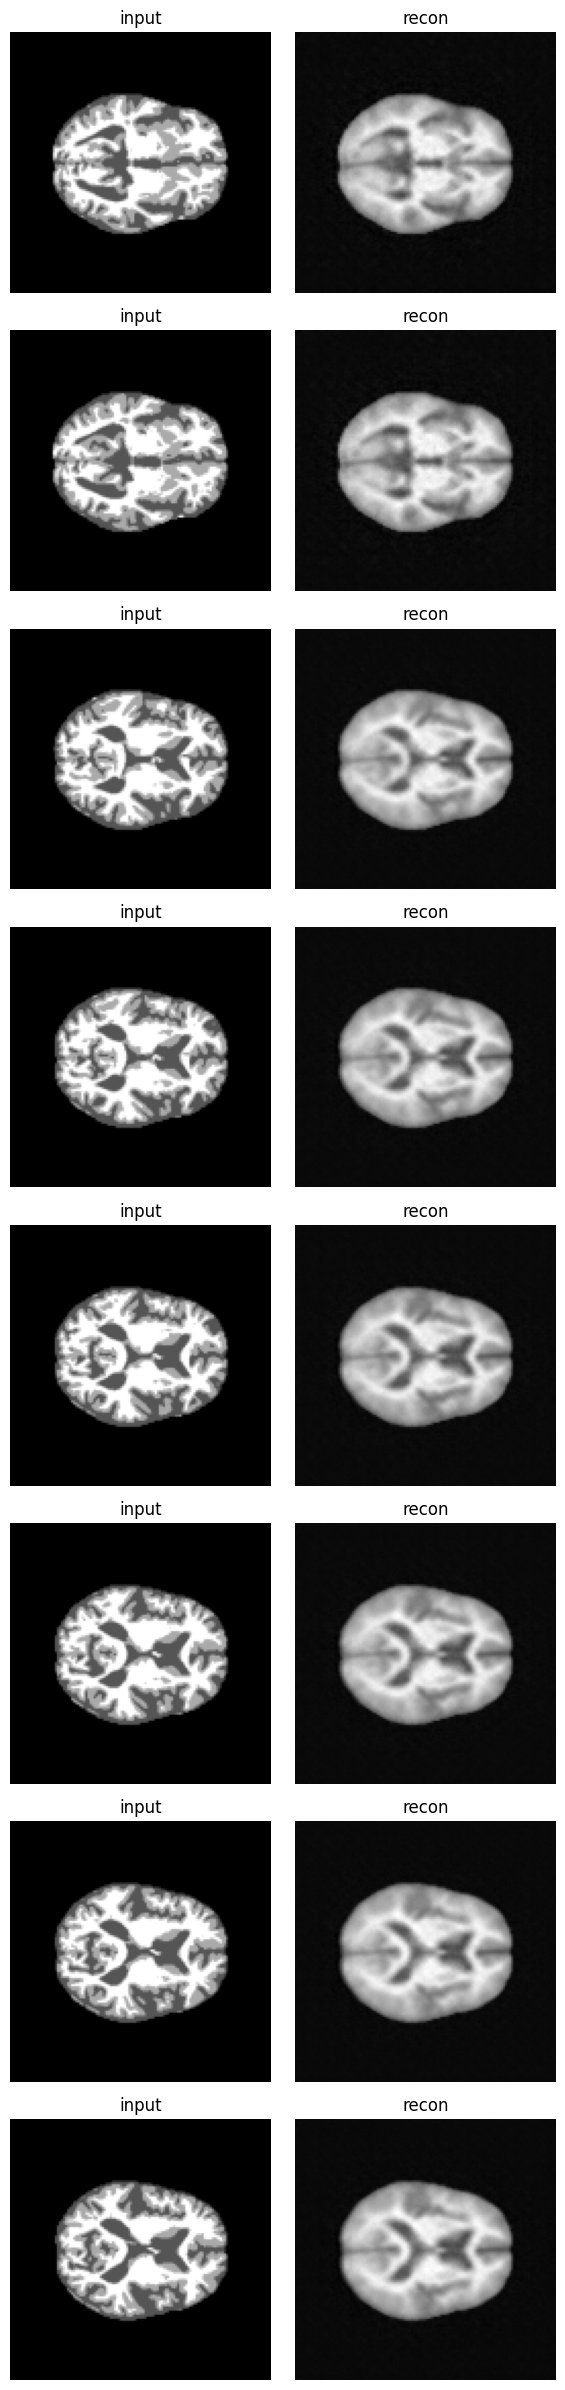

Saved: /content/results_png_z2/figs/latent_scatter.png


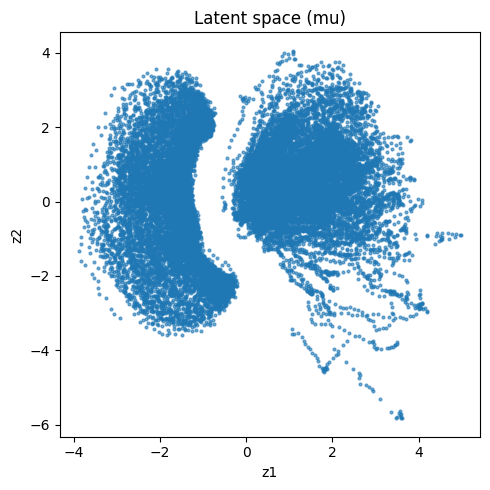

In [ ]:
# === Config (modify with your paths/hyperparams) ===
MODEL_PATH = "./results_png_z2/vae_best.pth"   # your best weights
DATA_ROOT  = "./data"                          # PNG data root (or a specific subdir)
SIZE       = 128
ZDIM       = 2                                 # z-dimension used during training
BATCH      = 128

# === Import your training module (PNG version) ===
import importlib.util, sys, os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
import torch

spec = importlib.util.spec_from_file_location("vae_png", "/content/train_vae_png.py")
m = importlib.util.module_from_spec(spec); sys.modules["vae_png"] = m; spec.loader.exec_module(m)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Save directory (new) ===
SAVE_ROOT = os.path.dirname(os.path.abspath(MODEL_PATH))  # e.g., ./results_png_z2
FIG_DIR   = os.path.join(SAVE_ROOT, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

# === Dataset & DataLoader (PNG version) ===
ds = m.PNGDataset(DATA_ROOT, target_hw=(SIZE, SIZE))
dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# === Model & Weights ===
vae = m.VAE(zdim=ZDIM).to(device)
state = torch.load(MODEL_PATH, map_location=device)
vae.load_state_dict(state)
vae.eval()

# === 1) Input vs Reconstruction visualization ===
def show_recons(n_show=6):
    import math
    with torch.no_grad():
        xb, _ = next(iter(dl))
        xb = xb.to(device)
        xr, mu, lv, z = vae(xb)
    xb = xb[:n_show].detach().cpu().numpy()     # [n,1,H,W]
    xr = xr[:n_show].detach().cpu().numpy()

    cols = 2
    rows = n_show
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n_show):
        plt.subplot(rows, cols, i*2+1); plt.imshow(xb[i,0], cmap="gray"); plt.axis("off"); plt.title("input")
        plt.subplot(rows, cols, i*2+2); plt.imshow(xr[i,0], cmap="gray"); plt.axis("off"); plt.title("recon")
    plt.tight_layout()

    # Save figure
    out_path = os.path.join(FIG_DIR, f"recons_{n_show}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    plt.show()
    plt.close()

show_recons(n_show=8)

# === 2) Latent space scatter plot (only when zdim=2) ===
if ZDIM == 2:
    Z = []
    with torch.no_grad():
        for xb, _ in dl:
            xb = xb.to(device)
            mu, lv = vae.enc(xb)
            # Using mean mu as the representative of z is more stable
            Z.append(mu.detach().cpu().numpy())
    Z = np.concatenate(Z, axis=0)  # [N,2]

    plt.figure(figsize=(5,5))
    plt.scatter(Z[:,0], Z[:,1], s=4, alpha=0.6)
    plt.title("Latent space (mu)"); plt.xlabel("z1"); plt.ylabel("z2")
    plt.tight_layout()

    # Save figure
    out_path = os.path.join(FIG_DIR, "latent_scatter.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    plt.show()
    plt.close()
else:
    print(f"ZDIM={ZDIM}, skipping 2D scatter. For 2D visualization, see UMAP in the next cell.")


Saved: /content/results_png_z2/figs/manifold_grid_15x15_zlim3.0.png


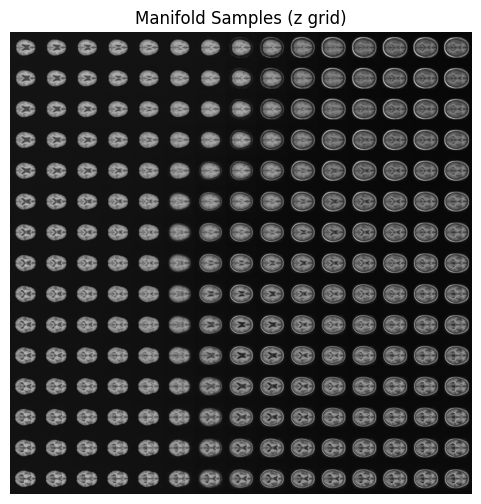

In [ ]:
import os, numpy as np, torch, matplotlib.pyplot as plt
from math import sqrt, ceil

# Create save directory (reuse FIG_DIR if already defined; otherwise default to ./results_png_z2/figs)
FIG_DIR = globals().get("FIG_DIR", "./results_png_z2/figs")
os.makedirs(FIG_DIR, exist_ok=True)

# === z=2: sample on a [-3,3]x[-3,3] grid, decode into tiled images ===
def manifold_grid(vae, grid_n=15, zlim=3.0, out_size=SIZE):
    vae.eval()
    zs1 = np.linspace(-zlim, zlim, grid_n)
    zs2 = np.linspace(-zlim, zlim, grid_n)
    tiles = []
    with torch.no_grad():
        for y in zs2:  # rows
            row_imgs = []
            for x in zs1:  # cols
                z = torch.tensor([[x, y]], dtype=torch.float32, device=device)  # [1,2]
                xr = vae.dec(z)                                                # [1,1,H,W]
                img = xr[0,0].detach().cpu().numpy()
                row_imgs.append(img)
            tiles.append(np.concatenate(row_imgs, axis=1))
    grid = np.concatenate(tiles, axis=0)  # (grid_n*H, grid_n*W)
    plt.figure(figsize=(6,6))
    plt.imshow(grid, cmap="gray")
    plt.axis("off"); plt.title("Manifold Samples (z grid)")

    # Save figure
    out_path = os.path.join(FIG_DIR, f"manifold_grid_{grid_n}x{grid_n}_zlim{zlim:.1f}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    plt.show()
    plt.close()

if ZDIM == 2:
    manifold_grid(vae, grid_n=15, zlim=3.0, out_size=SIZE)
else:
    print("zdim != 2: use UMAP to reduce high-dimensional z into 2D visualization…")
    # === Optional: UMAP to reduce z to 2D (when ZDIM > 2) ===
    # Install dependency (needed on first run)
    !pip -q install umap-learn

    import umap
    from tqdm import tqdm

    # Collect z (use mu as representative)
    Z = []
    with torch.no_grad():
        for xb, _ in tqdm(dl, desc="Collecting z (mu)"):
            xb = xb.to(device)
            mu, lv = vae.enc(xb)
            Z.append(mu.detach().cpu().numpy())
    Z = np.concatenate(Z, axis=0)   # [N, ZDIM]

    reducer = umap.UMAP(n_components=2, random_state=42)
    Z2 = reducer.fit_transform(Z)   # [N,2]

    plt.figure(figsize=(5,5))
    plt.scatter(Z2[:,0], Z2[:,1], s=3, alpha=0.6)
    plt.title(f"UMAP of latent (Z={ZDIM} -> 2D)")
    plt.tight_layout()

    # Save figure
    out_path = os.path.join(FIG_DIR, f"umap_latent_Z{ZDIM}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

    plt.show()
    plt.close()
